# Assignment 2

In [1]:
#importing all modules
import numpy as np
import math
from scipy.sparse import coo_matrix, linalg, random
import matplotlib.pyplot as plt
import time
from timeit import timeit
from matplotlib.colors import LogNorm
from numba import cuda
import numba

cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-6f8b48e4-96a6-5459-a499-158cd70cc331
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## Part 1

Creating a function that produces a sparse matrix and vector that together form the simultaneous equations of the time harmonic wave equation. Creates the matrix in the CSR format.

In [ ]:
def make_matrix_sparse(N):
    """Creates a matrix and an associated vector of size N, which represet simultaneous solutions to the time 
    harmonic wave problem between in the range x = [0,1]. The matrix is created in the CSR format.
    Inputs
    N: size of matrix
    Returns
    A: matrix of coefficients
    f: vector of known values
    """
    
    #set values
    h = 1/N
    k = (29*np.pi)/2
    
    #create arrays of values
    rows = np.concatenate((np.arange(1,N),np.arange(1,N),np.arange(1,N),np.array([0,N])))
    cols = np.concatenate((np.arange(1,N),np.arange(0,N-1),np.arange(2,N+1),np.array([0,N])))
    data = np.concatenate((np.ones(N-1)*(2-h**2 * k**2),np.ones(N-1)*(-1),np.ones(N-1)*(-1),np.array([1,1])))
    f = np.concatenate((np.zeros(N),np.array([1])))

    #convert arrays into csr form
    A = coo_matrix((data, (rows, cols)), ((N+1), (N+1))).tocsr()
    
    return A, f

Running this function to find the wave amplitudes at three different resolutions, x = 0.1, 0.01 and 0.001. These are then plotted on three different subplots for comparison. 

### Plotting the Time Harmonic Wave Equation Solutions

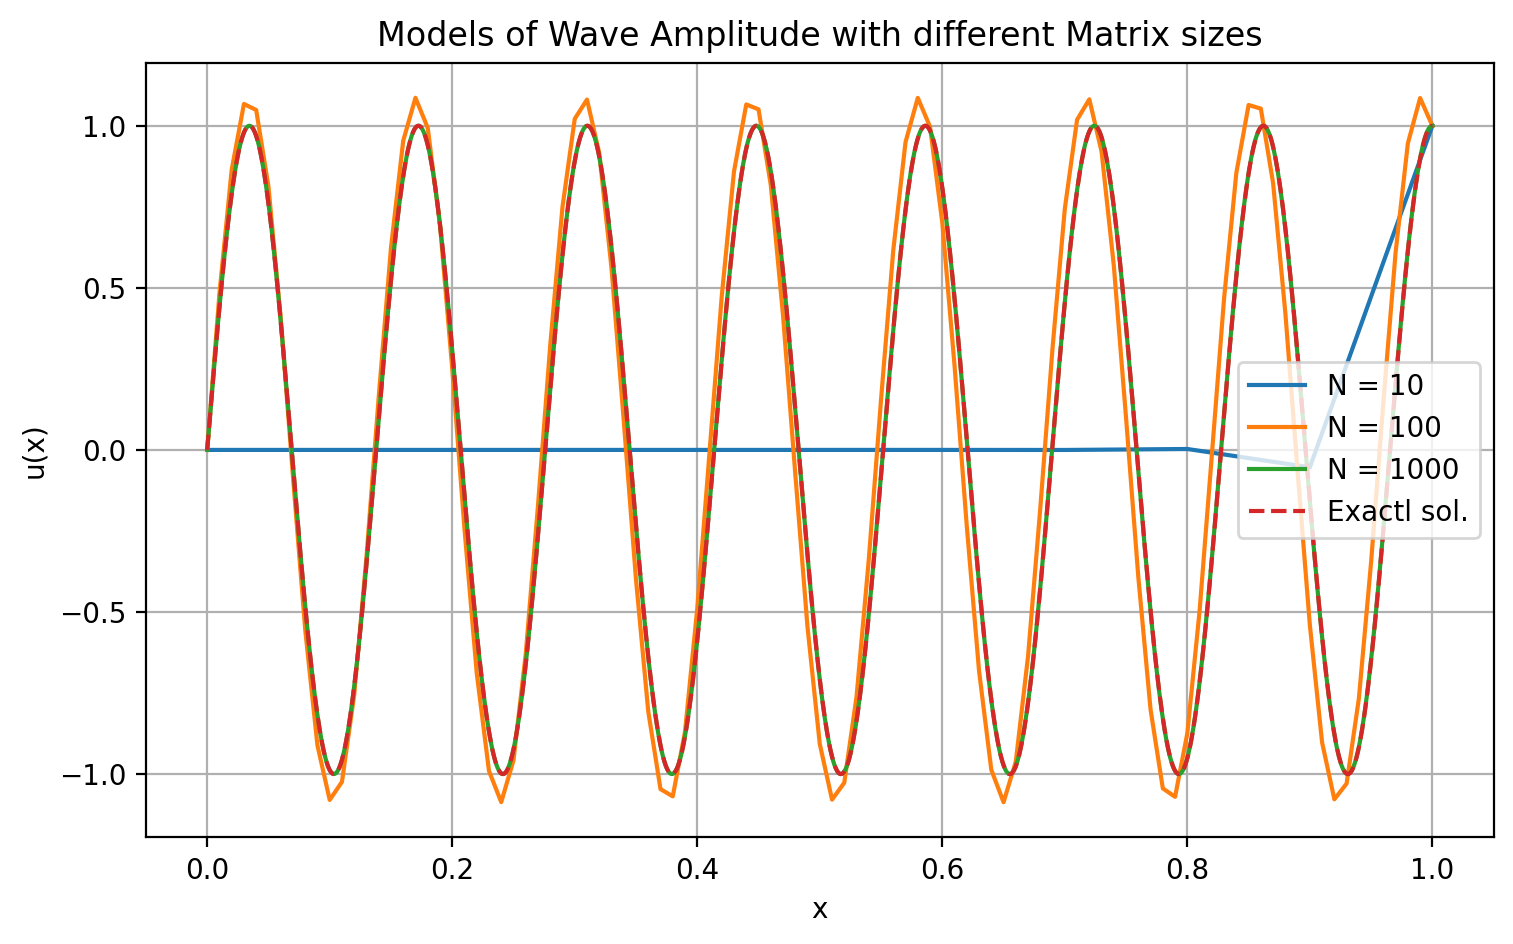

In [ ]:
#creating figure
fig, ax = plt.subplots(1,figsize=(8,5), dpi=200)
k = (29*np.pi)/2

for i, N in enumerate([10,100,1000]):
    A, f = make_matrix_sparse(N)
    b = linalg.spsolve(A,f)
    x = np.linspace(0,1,N+1)
    ax.plot(x, b,label=f'N = {N}')

#plotting
ax.set_title('Models of Wave Amplitude with different Matrix sizes')
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
x = np.linspace(0,1,10000)
ax.plot(x,np.sin(k*x),label='Exactl sol.', linestyle='--')
ax.legend()

The three models show the wave amplitude in the range x = [0,1]. The plots with matrix size 100 and 1000 are fairly similar in form and in scale. The N = 10 plot, however, has a very odd form that suggests the low resolution and large $\delta$x  cannot be used for the finite differences approximation. Naturally, we would expect the N = 1000 matrix to be closest to the actual solution. This is because it has a higher resolution than the other models and so will reflect a continuous model more acurately, it also has smaller $\delta$x and so creates more accurate approximations.

### Plotting the Maximum error of the model for various N

Below the maximum error between the discrete model used and the analytical model for each matrix size is plotted over the matrix size.

In [ ]:
#creating arrays
N_vals = np.logspace(1,6,1000,dtype=int)
store = np.zeros(len(N_vals))
k = (29*np.pi)/2

#finding maximum error values for each N
for i, N in enumerate(N_vals):
    A, f = make_matrix_sparse(N)
    b = linalg.spsolve(A,f) #model values
    x = np.linspace(0,1,N+1) #x values
    error_arr = abs(b - np.sin(k*x))
    store[i] = np.amax(error_arr)

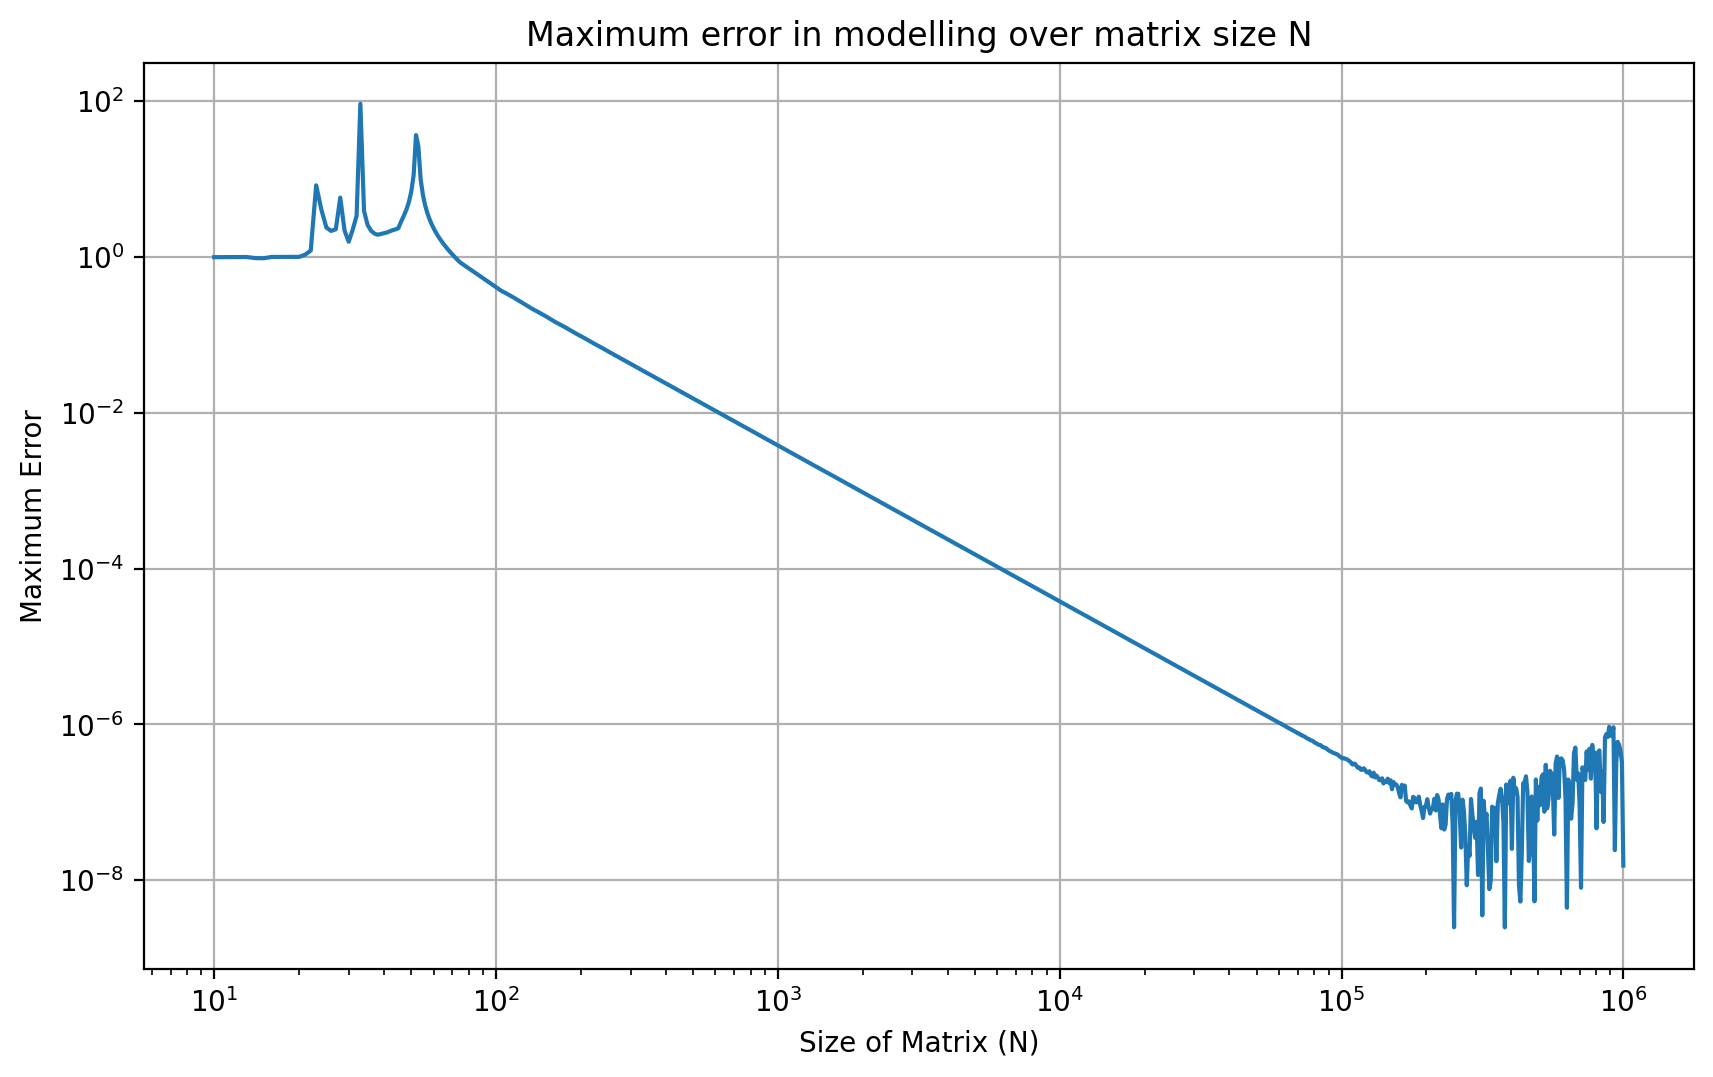

In [ ]:
#plotting the maximum error
plt.figure(figsize=(10,6), dpi=200)
plt.plot(N_vals,store)
plt.title('Maximum error in modelling over matrix size N')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Maximum Error')
plt.xlabel('Size of Matrix (N)')
plt.grid()

In the graph it is possible to see the 'quirks' of the harmonic approximation with a matrix size around N = 50. This likely occurs because the finite differences approximation does not hold for $\delta$x = 0.02 and larger. At N = 70 and larger, the maximum error begins to decrease exponentially until just larger than N = 100,000. 

### Plotting Time required to Solve the Wave Equation

Below, the time required to linearly solve the harmonic wave equations is plotted for various matrix sizes. 

In [ ]:
#creating arrays
N_vals2 = np.logspace(1,6,1000,dtype=int)
store2 = np.zeros(len(N_vals2))
k = (29*np.pi)/2
num_repeats = 1

#finding maximum error values for each N
for i, N in enumerate(N_vals2):
    start = time.time()
    A, f = make_matrix_sparse(N)
    store2[i] = timeit(lambda: linalg.spsolve(A,f),number = num_repeats)
    end = time.time()

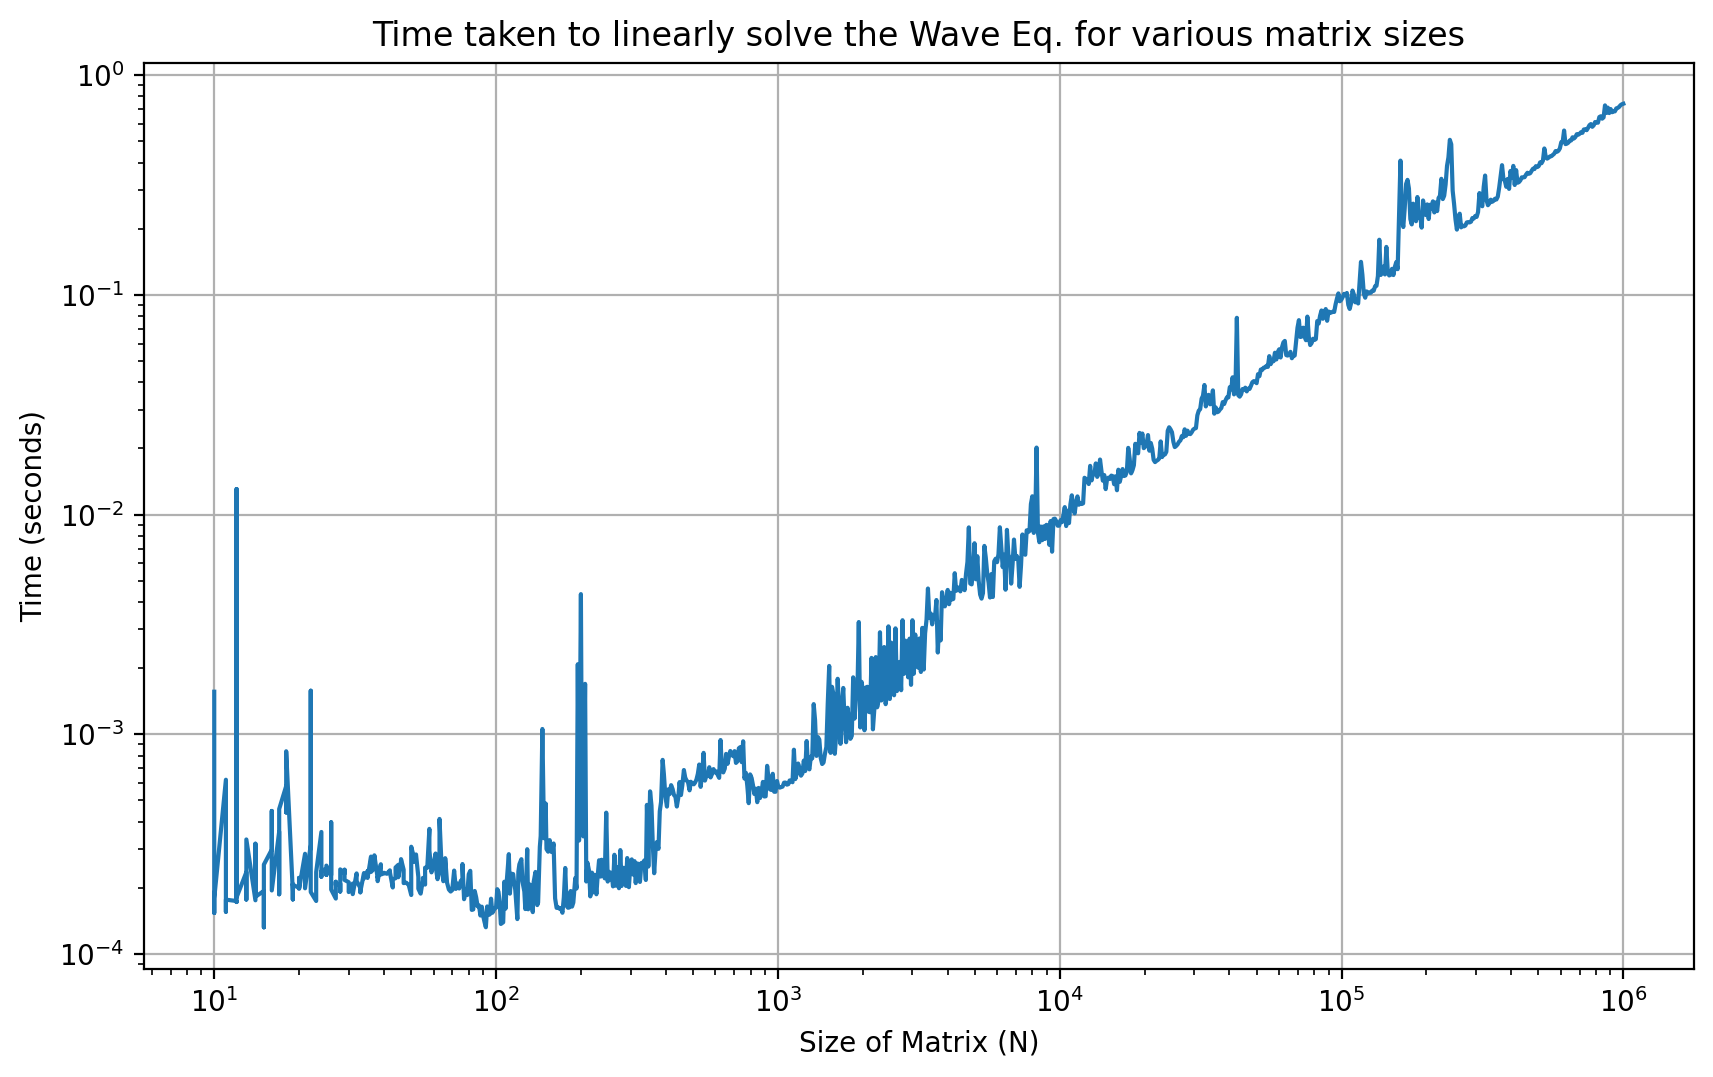

In [ ]:
#plotting the maximum error
plt.figure(figsize=(10,6), dpi=200)
plt.plot(N_vals2,store2)
plt.title('Time taken to linearly solve the Wave Eq. for various matrix sizes')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Time (seconds)')
plt.xlabel('Size of Matrix (N)')
plt.grid()

The graph above shows the timings for linear matrix solving to be around constant for N=10 - N=120. For larger values of N the time taken increases exponentionally with N, there is however, a lot of noise, so this is not a perfect correlation.

The maximum error does not reliably drop below $10^{-8}$ for any value of N but in the range N = [$10^{5}$,$10^{6}$] it does drop below $10^{-8}$ at some points, although these values are very unstable. This seems to be a quirk of an overly high resolution. As N increases further the maximum error begins to unstably increase again. The point with the lowest maximum error potential would be from N = 250,000 - 350,000, therefore the best value to select is 200,000. The time expected for the calculation is around 0.2-0.4 seconds, this expectation is made using the graph of timings measured for the same spread of matrix sizes.

### Calculating the max error and timing for a matrix of N = 379,821

In [ ]:
N = 200000

#calculatingm max error and time taken
A, f = make_matrix_sparse(N)
start = time.time()
b = linalg.spsolve(A,f) #model values
end = time.time()
x = np.linspace(0,1,N+1) #x values
error_arr = abs(b - np.sin(k*x))
max_error = np.amax(error_arr)

print('Time:', np.round(end-start, decimals=5),'seconds')
print('Max error:', np.round(max_error , decimals=13))

Time: 0.15007 seconds
Max error: 1.085645e-07


The error does turn out to be larger than $10^{-8}$, this is because of the lack of correlation between matrix size and maximum error for matrix sizes around 200,000. The instability around this size inhibits the suggestion of a good matrix size unless the minimum error matrix size is chosen directly from the measurements themselves. Looking at the max error graph it seems that making N any larger would not offer any benefits, so in conclusion it does not seem possible to suggest a general matrix size to solve with an error less than $10^{-8}$, unless it is chosen from pre-made measurements. The solving time here does not play into the validity of the choice as 0.15 seconds is not a long time to solve for one equation.

## Part 2

Implementing an iterative scheme for heat modelling in a rod.

In [ ]:
def rod_heat(N,time):
    """Calculates the heat dissipation in a rod of for 1 seconds by breaking the rod into N sections and the second 
    of N time-steps.
    Inputs
    N: number of spatial divisions rod is broken into and the number of time-steps per second
    time: number of seconds
    Returns
    An array of the heat distribtion across the rod at at a certain time."""
    
    #creating the initial array
    heat_arr = np.zeros(((N*time)+1,N+3))
    heat_arr[0,1] = 10
    heat_arr[0,N+1] = 10
    h = 1/N
    
    #looping over the timesteps
    for i in range(N*time):
        heat_arr[i+1,:] = (heat_arr[i,:] + (np.roll(heat_arr[i,:],1)-2*heat_arr[i,:]+ np.roll(heat_arr[i,:],-1))/(1000*h))
        heat_arr[i+1,0:2] = [0,10]
        heat_arr[i+1,-2:] = [10,0]
    
    return heat_arr[N*time,:]

Below the temperature distributions of a rod of N segments are plotted for a 1,2 and 10 seconds of disspiation. Each second in the simulation is also broken down into N time steps.

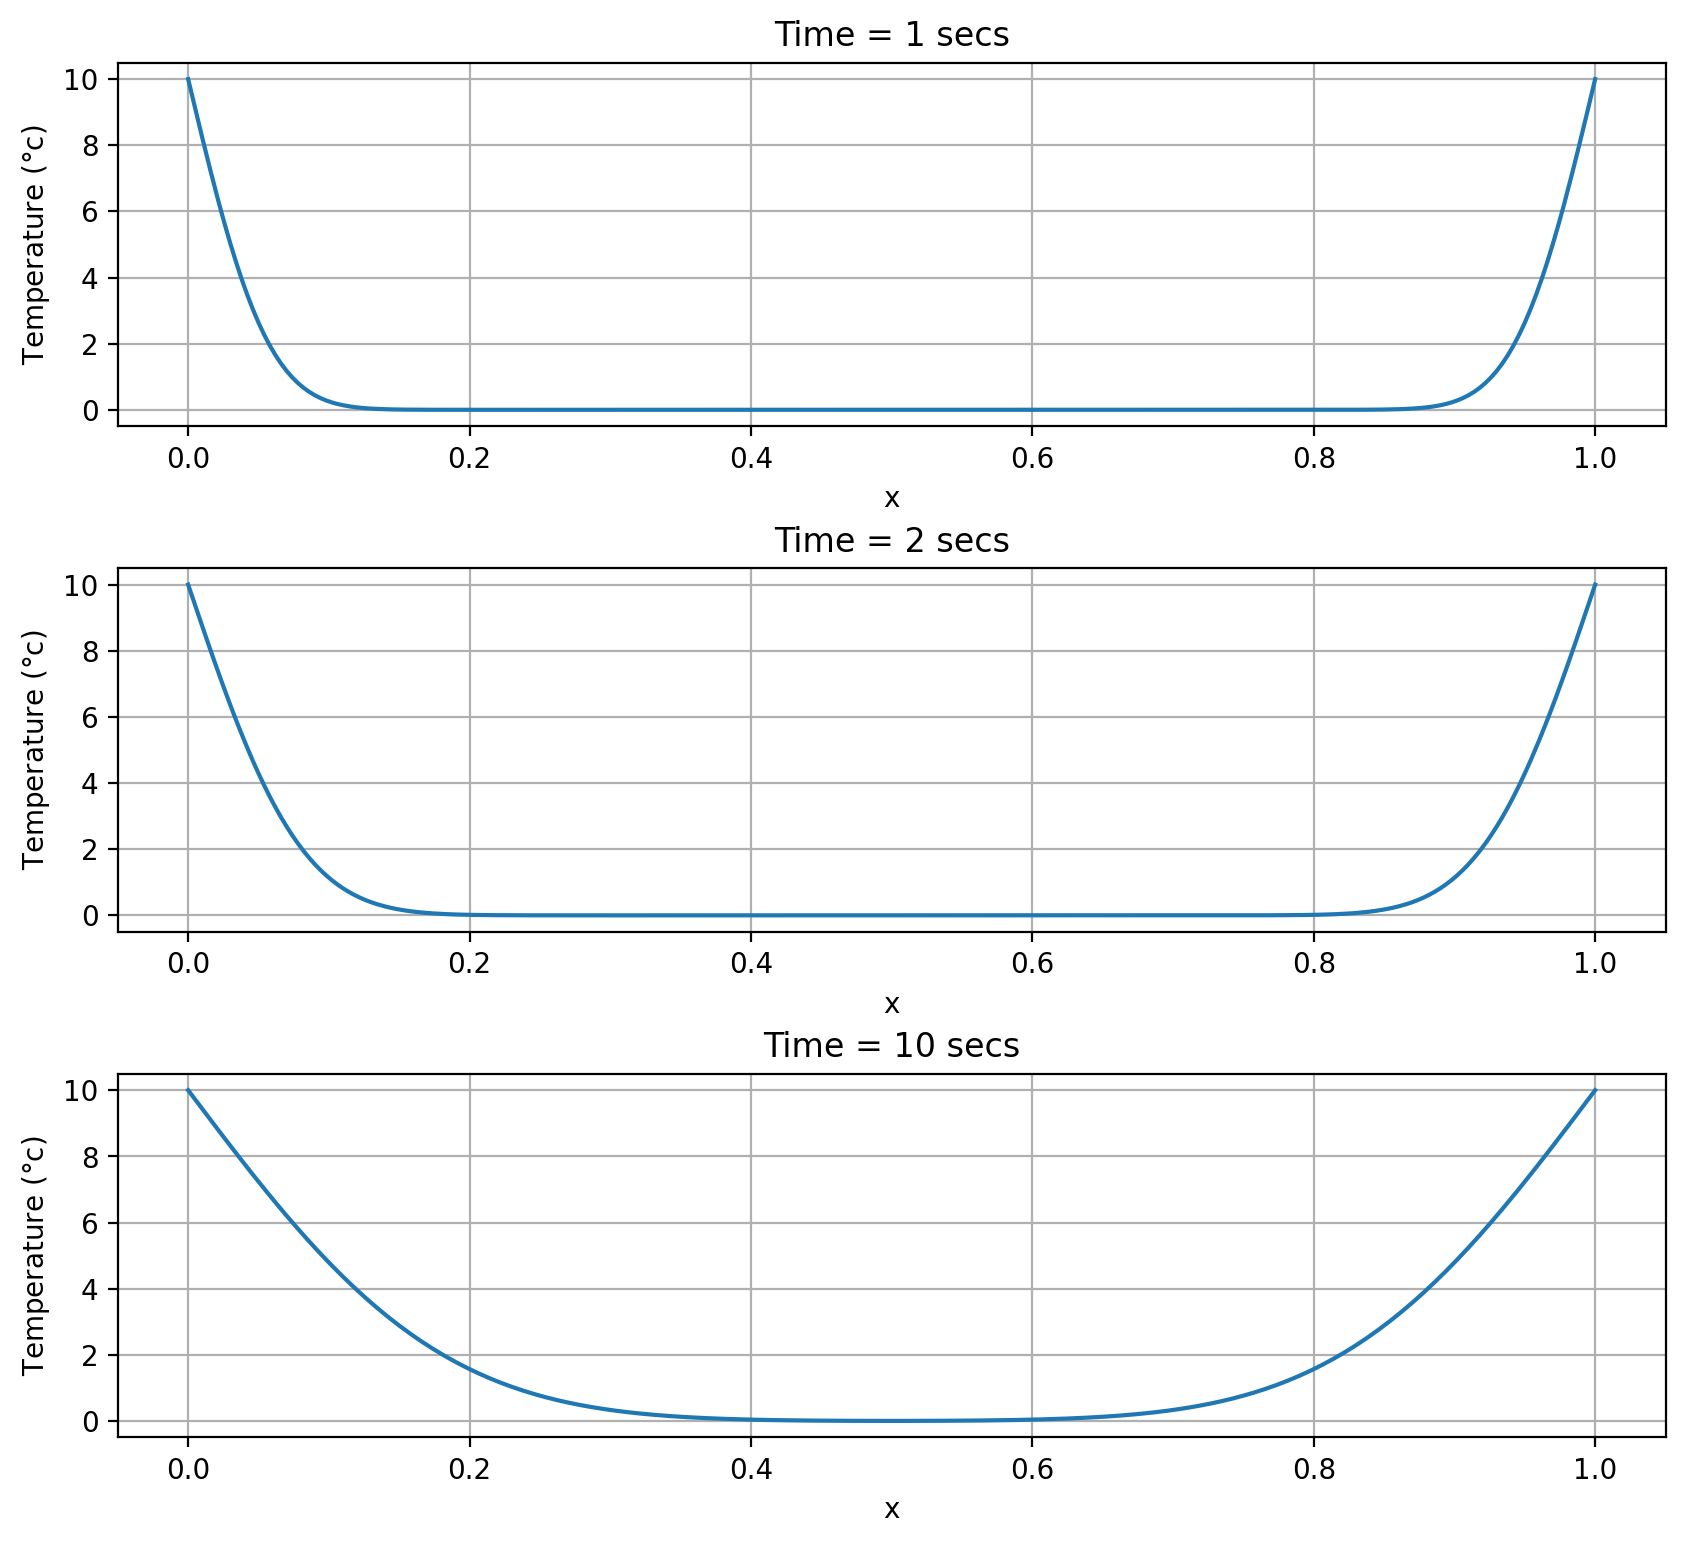

In [ ]:
#plotting the temperatures
fig, ax = plt.subplots(3,figsize=(9,8),dpi=200)
fig.tight_layout(pad=3)
N = 500
time = np.array([1,2,10])

for i, time in enumerate(time):
    rod = rod_heat(N,time)
    
    #plotting the graphs
    x = np.linspace(0,1,N+1)
    ax[i].plot(x,rod[1:-1])
    ax[i].set_xlabel('x')
    ax[i].set_ylabel(f'Temperature ($\degree$c)')
    ax[i].set_title(f'Time = {time} secs')
    ax[i].grid()

A value for N of 500 was chosen such that the increments were not too small to cause decimal erros and that the finite differences approximation would likely hold well. This is because in part one the finite differences approximation failed for N $\approx$ 200 as the $\delta$x was not small enough. However, N was made smaller than 1000 as above this value the approximation method diverges and becomes useless, and at values near 1000 it will potentially become unstable.

### CUDA GPU Implementation 

Below a CUDA implementation of the same iterator is created and plotted. It uses shared memory within a block to increase computation speed. It only has 1 block of size 1024, and so for N larger than 1024 it will not properly calculate as the array is not shared to the other blocks. This is fine though as N > 1000 would cause the model itself to break, so no extra constraints have been placed on the system.

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


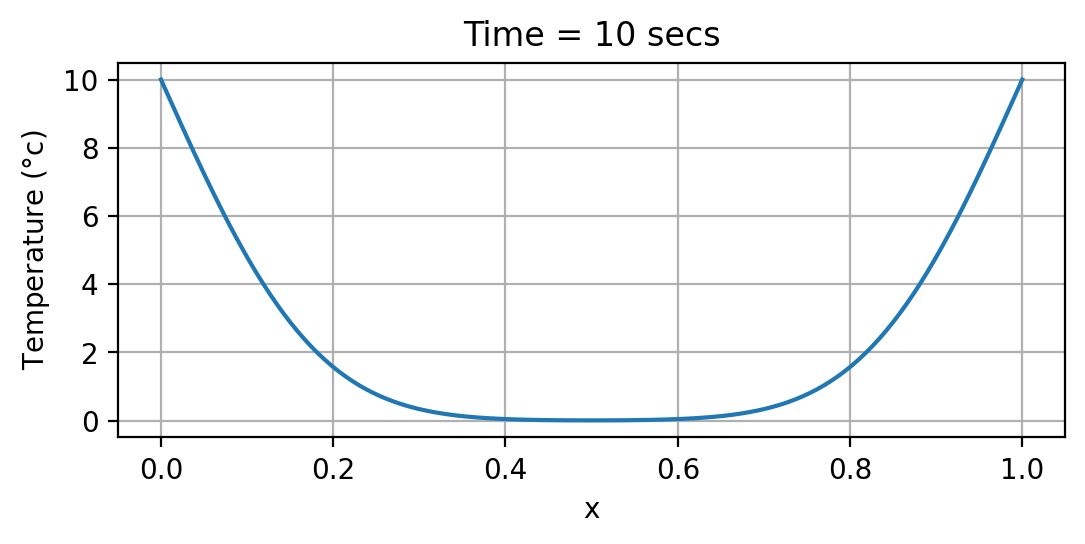

In [2]:
#creating the initial heat array
N = 500
N_1 = N +1
time = 10
heat_arr = np.zeros((2,N+1), dtype='float32')
heat_arr[0,0] = 10
heat_arr[0,N] = 10

#set grid structure
threadsperblock = 1024
blockspergrid = (heat_arr.shape[1] + (threadsperblock - 1)) // threadsperblock


@cuda.jit
def heat_evaluation_cuda(heat_arr,time,N):

    #create shared ar
    s_heat = cuda.shared.array((N_1), dtype=numba.float32)
    s_step = cuda.shared.array((N_1), dtype=numba.float32)

    h = 1/N

    #identifying coordinates
    pos = cuda.grid(1)

    if (pos > N):
        #quit if outside of x value range
        return

    #set initial heat values
    s_heat[pos] = heat_arr[0,pos]

    cuda.syncthreads() #re-sync threads

    for i in range(N*time):
        #calculate next heat values
        if (pos == 0) or (pos == N):
            s_step[pos] = 10
        else:
            s_step[pos] = (s_heat[pos] + (s_heat[pos-1] - 2*s_heat[pos] + s_heat[pos+1])/(1000*h))
        s_heat[pos] = s_step[pos]
        cuda.syncthreads() #re-sync threads

    heat_arr[1,pos] = s_heat[pos]

    
    
#running model
heat_evaluation_cuda[blockspergrid, threadsperblock](heat_arr,time,N)

#plotting the temperatures
fig, ax = plt.subplots(1,figsize=(6,3),dpi=200)
fig.tight_layout(pad=3)

rod = heat_arr[1,:] #finding final heat distribution
x = np.linspace(0,1,N+1)
ax.plot(x,rod)
ax.set_xlabel('x')
ax.set_ylabel(f'Temperature ($\degree$c)')
ax.set_title(f'Time = {time} secs')
ax.grid()

This plot at 10 seconds is identical to the plot above from the CPU implementation and therefore shows the CUDA implementation works well.

### Modelling Time for centre of rod to reach 9.8$^{\circ}$c

Below is some code that plots the heat of the centre of the rod over time, this allows an extrapolation to see how long it will take for the centre of the rod to reach 9.8$^{\circ}$c.

In [ ]:
#saving heat values over a range of times
times = np.linspace(0,500,num=30, dtype='int')
heat_store = np.zeros(len(times))
N = 500
for i, time in enumerate(times):
    heat_store[i] = rod_heat(N,time)[int((N+1)/2)]

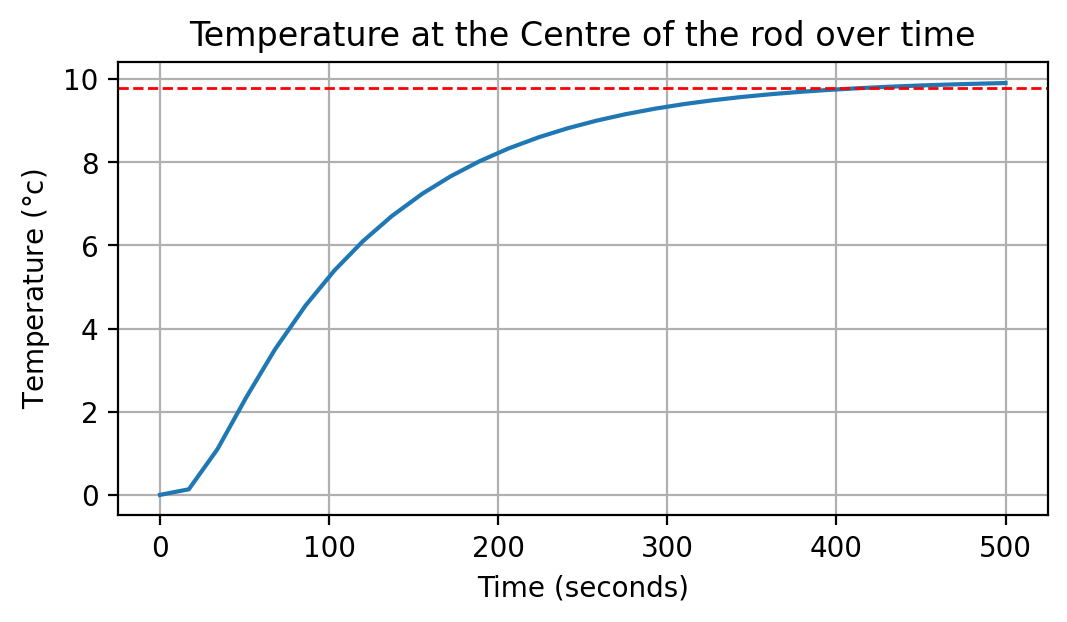

In [ ]:
#plotting the heat values over time
plt.figure(dpi=200,figsize=(6,3))
plt.plot(times,heat_store)
plt.axhline(y=9.8, color='r', linestyle='--',linewidth=1)
plt.title('Temperature at the Centre of the rod over time')
plt.ylabel(f'Temperature ($\degree$c)')
plt.xlabel('Time (seconds)')
plt.grid()

In the plot above its possible to see the temperature at the centre of the rod increases very slowly in the first 20 seconds. Then after this it increases faster and linearly with time from t = 20 to t $\approx$ 90 seconds, after this point and exponential decrease in rate occurs as the temperature comes closer 10$^{\circ}$c. From drawing a line on the graph at 9.8$^{\circ}$c, it seems that the temperature at the middle of the rod would surpass 9.8$^{\circ}$c at t $\approx$ 420 seconds.